In [8]:

# 0) Imports and utility setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Plotting defaults (matplotlib only; no seaborn)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.grid'] = False

RANDOM_SEED_GLOBAL = 7
np.random.seed(RANDOM_SEED_GLOBAL)



## 1) Data Generating Process (DGP), Train/Test Split, and Linear Model
We simulate features $x_1,\dots,x_6$ and a (simplified) regression target:

\[
\begin{aligned}
x_1 &\sim \mathcal{N}(0,1), \quad x_2 = x_1 + \varepsilon_2,\; \varepsilon_2 \sim \mathcal{N}(0, 0.25^2), \\
x_3, x_4, x_5, x_6 &\sim \mathcal{N}(0,1), \\
y &= 3x_1 + 2\sin(2 x_4) + 1.5 x_3^2 + \varepsilon, \\
\varepsilon &\sim \mathcal{N}(0, 0.7^2).
\end{aligned}
\]

- **x1**: strong linear effect  
- **x2**: redundant proxy for x1 (correlated)  
- **x3**: quadratic (smooth nonlinearity)  
- **x4**: sinusoidal nonlinearity  
- **x5, x6**: noise

> Hint: How will a purely linear model approximate $\sin(2 x_4)$ and $x_3^2$? Think about local linearization around 0 and the symmetry of $x_3^2$ when predicting, and what this implies for coefficients vs. PFI.

We split into **65% train / 35% test** and fit a **Linear Regression**.


In [9]:

# 1) Generate data (simplified DGP)
rng = np.random.RandomState(RANDOM_SEED_GLOBAL)
n = 1200

x1 = rng.normal(0, 1, n)
x2 = x1 + rng.normal(0, 0.25, n)            # correlated with x1 (redundant)
x3 = rng.normal(0, 1, n)
x4 = rng.normal(0, 1, n)
x5 = rng.normal(0, 1, n)                     # noise
x6 = rng.normal(0, 1, n)                     # noise

signal = (
    3.0*x1                                  # strong linear
    + 2.0*np.sin(2.0*x4)                     # smoother sinusoidal (no interaction)
    + 1.5*(x3**2)                            # quadratic nonlinearity
)

y = signal + rng.normal(0, 0.7, n)

X = pd.DataFrame({'x1':x1,'x2':x2,'x3':x3,'x4':x4,'x5':x5,'x6':x6})
y = pd.Series(y, name='y')

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=11)

# Fit Linear Regression
lin = LinearRegression().fit(X_train, y_train)

print("Shapes — X_train:", X_train.shape, "X_test:", X_test.shape)


Shapes — X_train: (780, 6) X_test: (420, 6)



## 2) Brief recap: How PFI is computed (for one feature)
1. Compute the **baseline** error (MSE) on a dataset (train or test).  
2. **Permute** one feature column (shuffle values across rows), keep the rest fixed.  
3. Predict again and recompute the error.  
4. **PFI** for that feature is the **increase** in error: \( \Delta \text{MSE} = \text{MSE}_{\text{perm}} - \text{MSE}_{\text{base}} \).  
5. Repeat the permutation several times and **average** to stabilize the estimate (and report the std/SE as an error bar).


In [10]:
# 2) PFI function (modified to allow saving figures)

def permutation_feature_importance(model, X, y, n_perm=40, random_state=0):
    rng = np.random.RandomState(random_state)
    base_pred = model.predict(X)
    base_mse = mean_squared_error(y, base_pred)
    means, stds, cols = [], [], list(X.columns)
    for col in cols:
        deltas = []
        for _ in range(n_perm):
            Xp = X.copy()
            Xp[col] = rng.permutation(Xp[col].values)
            perm_pred = model.predict(Xp)
            deltas.append(mean_squared_error(y, perm_pred) - base_mse)
        means.append(float(np.mean(deltas)))
        stds.append(float(np.std(deltas)))
    df = pd.DataFrame({'feature': cols,'mean_delta_mse': means, 'std': stds}).sort_values('mean_delta_mse', ascending=False)
    return base_mse, df


def barplot_pfi(df, title, file_name=None):
    plt.figure()
    plt.bar(df['feature'], df['mean_delta_mse'], yerr=df['std'])
    plt.ylabel("Δ MSE after permutation")
    plt.title(title)
    plt.tight_layout()
    if file_name is not None:
        plt.savefig(file_name, dpi=180)
    plt.show()



## 3) Linear Regression — Baseline Errors and PFIs
Compute train/test MSE and the PFIs for the linear model, then interpret the barplots.


   Train MSE  Test MSE
0     6.2198    7.1312


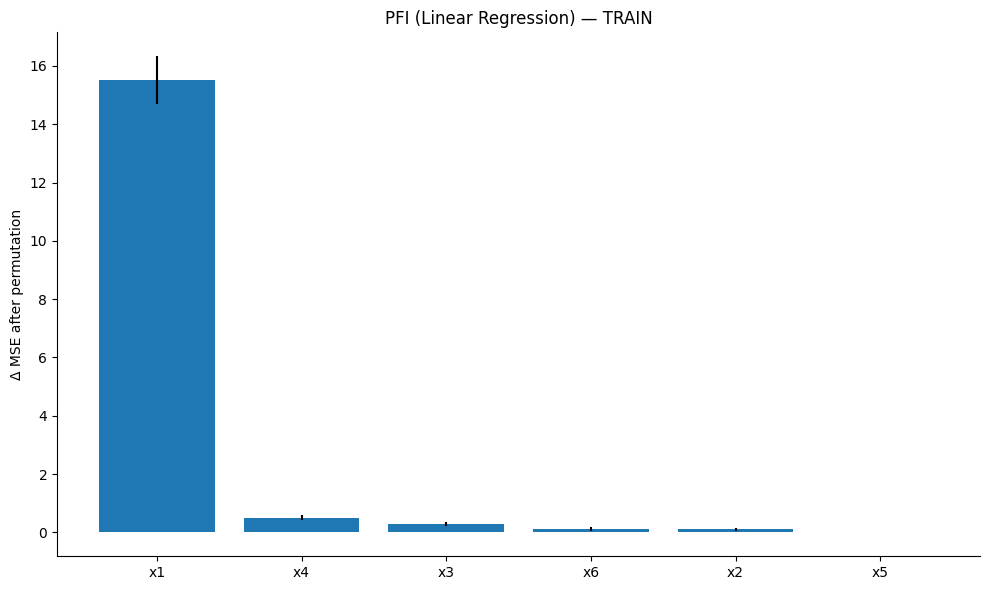

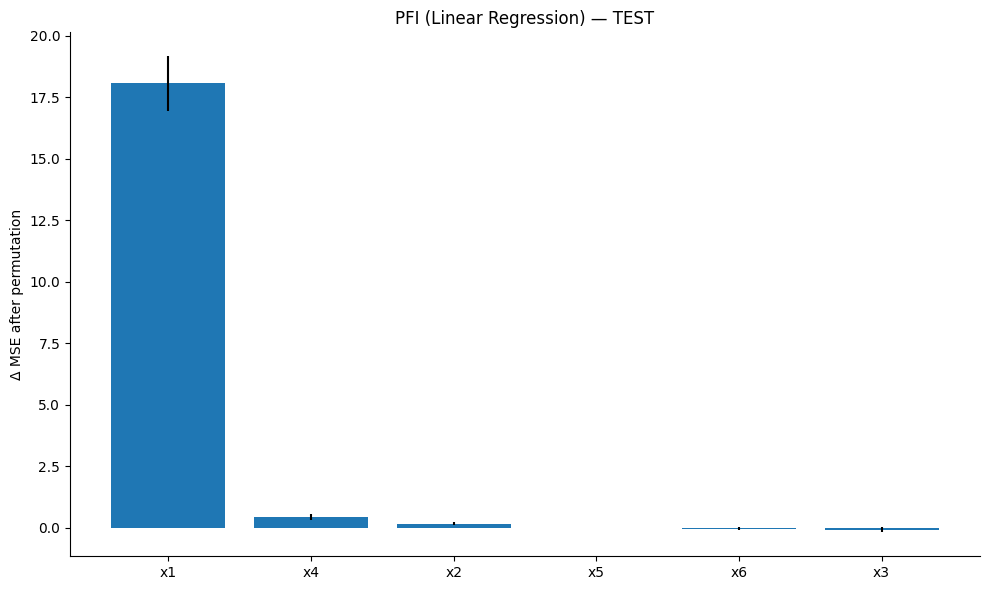

,feature,mean_delta_mse,std
0,x1,15.5145,0.8218
3,x4,0.4927,0.0850
2,x3,0.2961,0.0747
5,x6,0.1132,0.0534
1,x2,0.0967,0.0355
4,x5,0.0024,0.0075


In [16]:
# Linear model PFIs with saved plots
lin_tr_mse, lin_tr_pfi = permutation_feature_importance(lin, X_train, y_train, n_perm=40, random_state=1)
lin_te_mse, lin_te_pfi = permutation_feature_importance(lin, X_test,  y_test,  n_perm=40, random_state=2)

print(pd.DataFrame({'Train MSE':[lin_tr_mse], 'Test MSE':[lin_te_mse]}).round(4))

barplot_pfi(lin_tr_pfi, "PFI (Linear Regression) — TRAIN", file_name="fig-man/pfi_linear_train_.png")
barplot_pfi(lin_te_pfi, "PFI (Linear Regression) — TEST", file_name="fig-man/pfi_linear_test.png")

lin_tr_pfi.round(4)


## 4) Fit Gradient Boosting to capture nonlinearities
We fit a moderate-capacity GB (500 trees, depth 3) to learn the nonlinear patterns and interactions. Then we compute PFIs.


   Train MSE  Test MSE
0     0.0007     1.462


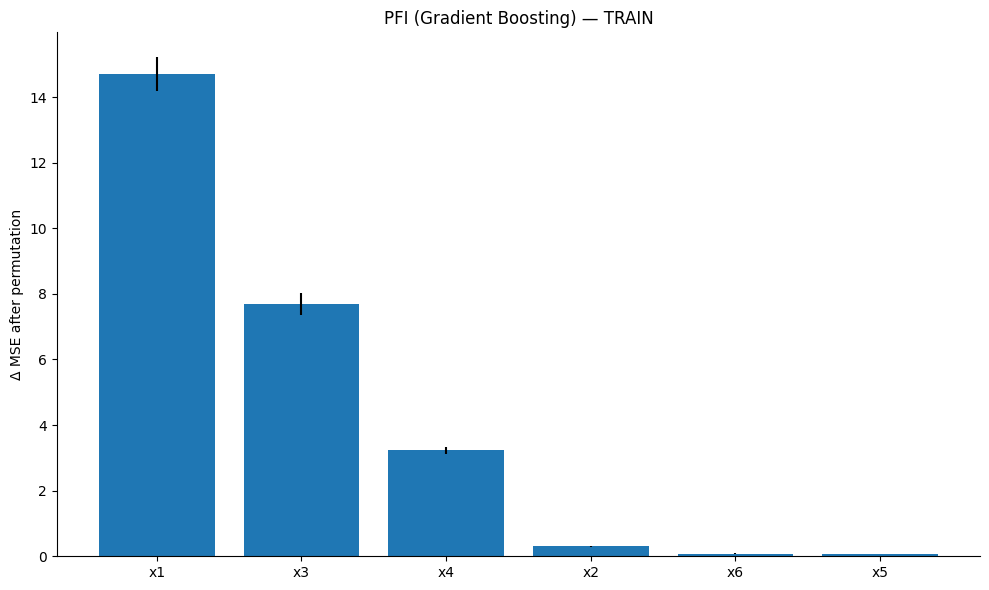

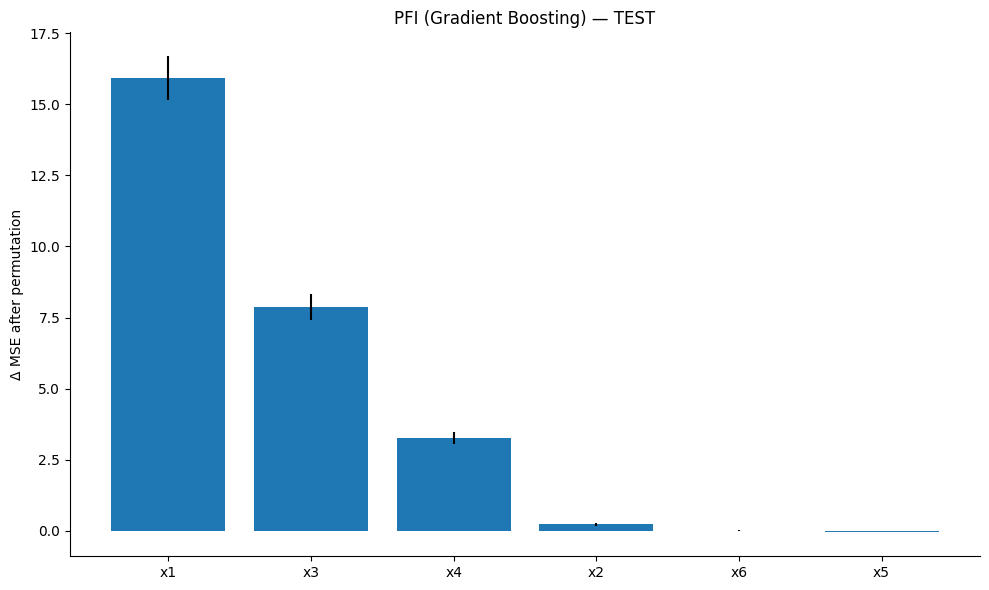

,feature,mean_delta_mse,std
0,x1,14.7031,0.5108
2,x3,7.6939,0.3404
3,x4,3.2312,0.1102
1,x2,0.3028,0.0173
5,x6,0.0813,0.0042
4,x5,0.0782,0.0041


In [17]:
# Gradient Boosting PFIs with saved plots
gbr = GradientBoostingRegressor(n_estimators=500, max_depth=5, learning_rate=0.1, subsample=0.9, random_state=11)
gbr.fit(X_train, y_train)

gbr_tr_mse, gbr_tr_pfi = permutation_feature_importance(gbr, X_train, y_train, n_perm=40, random_state=3)
gbr_te_mse, gbr_te_pfi = permutation_feature_importance(gbr, X_test,  y_test,  n_perm=40, random_state=4)

print(pd.DataFrame({
    'Train MSE':[gbr_tr_mse],
    'Test MSE':[gbr_te_mse]
}).round(4))

barplot_pfi(gbr_tr_pfi, "PFI (Gradient Boosting) — TRAIN", file_name="fig-man/pfi_gbr_train.png")
barplot_pfi(gbr_te_pfi, "PFI (Gradient Boosting) — TEST", file_name="fig-man/pfi_gbr_test.png")

gbr_tr_pfi.round(4)

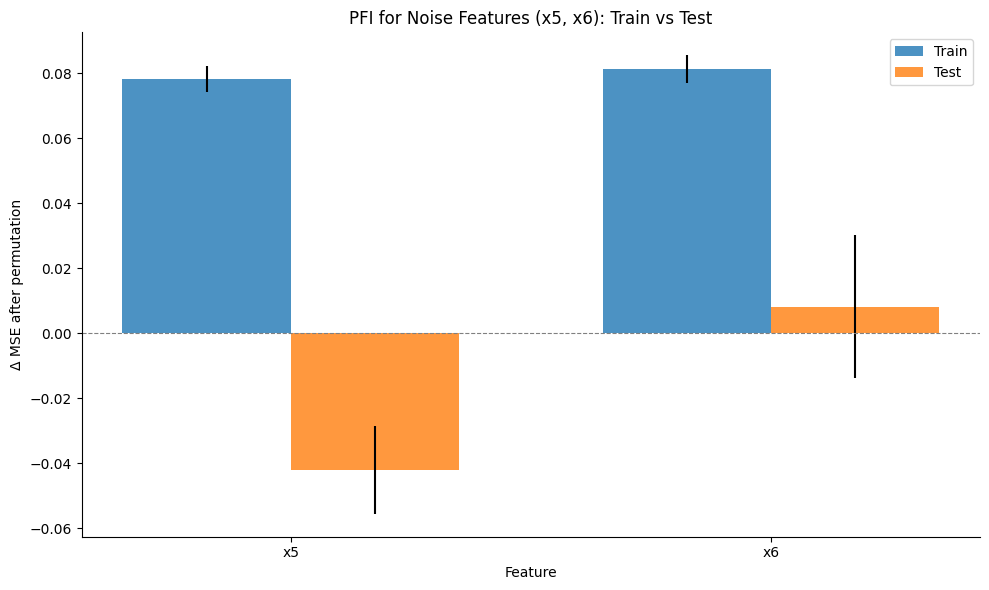

In [18]:
# Grouped bar plot comparing train vs test PFI for x5 and x6 (saved)
features_noise = ['x5', 'x6']

# Extract train PFI for x5, x6
train_vals = [
    gbr_tr_pfi[gbr_tr_pfi['feature']=='x5']['mean_delta_mse'].values[0],
    gbr_tr_pfi[gbr_tr_pfi['feature']=='x6']['mean_delta_mse'].values[0]
]
train_errs = [
    gbr_tr_pfi[gbr_tr_pfi['feature']=='x5']['std'].values[0],
    gbr_tr_pfi[gbr_tr_pfi['feature']=='x6']['std'].values[0]
]

# Extract test PFI for x5, x6
test_vals = [
    gbr_te_pfi[gbr_te_pfi['feature']=='x5']['mean_delta_mse'].values[0],
    gbr_te_pfi[gbr_te_pfi['feature']=='x6']['mean_delta_mse'].values[0]
]
test_errs = [
    gbr_te_pfi[gbr_te_pfi['feature']=='x5']['std'].values[0],
    gbr_te_pfi[gbr_te_pfi['feature']=='x6']['std'].values[0]
]

# Create grouped bar plot
x_pos = np.arange(len(features_noise))
width = 0.35

plt.figure()
plt.bar(x_pos - width/2, train_vals, width, yerr=train_errs, label='Train', alpha=0.8)
plt.bar(x_pos + width/2, test_vals, width, yerr=test_errs, label='Test', alpha=0.8)

plt.ylabel('Δ MSE after permutation')
plt.xlabel('Feature')
plt.title('PFI for Noise Features (x5, x6): Train vs Test')
plt.xticks(x_pos, features_noise)
plt.legend()
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.savefig("fig-man/pfi_noise_x5x6.png", dpi=180)
plt.show()


## 5) Contrast Train vs. Test PFIs for Gradient Boosting
- Which features drop the most from train to test? (Overfitting signal)  
- Which remain stable? (Generalizable signal)  
- Compare to the linear model PFIs: which features gained importance and why?


In [14]:
print("GBR train MSE:", gbr_tr_mse)
print("GBR test MSE:", gbr_te_mse)
print("Linear train MSE:", lin_tr_mse)
print("Linear test MSE:", lin_te_mse)

GBR train MSE: 0.0006954233811319985
GBR test MSE: 1.4619814410661383
Linear train MSE: 6.21975703710808
Linear test MSE: 7.131192014131739
